In [3]:
import sqlite3
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import re
import numpy as np
import plotly.express as px

In [4]:
# Big thanks to u/Yortos on GitHub for their iMessage analysis tutorial
# Check out their repository (which I got some of this code from) here:
    # https://github.com/yortos/imessage-analysis

# find your chat.db and establish a connection
conn = sqlite3.connect('/Users/USERNAME/Library/Messages/chat.db')
cur = conn.cursor()

# query the database to get all the table names
cur.execute(" select name from sqlite_master where type = 'table' ")

for name in cur.fetchall():
    print(name)
    
# If you get an error connecting to chat.db "can't connect", you may need to change your privacy settings
# I'm assuming if you're looking at iMessage data, you're probably on a Mac
# This reddit thread was helpful with the issue:
    # https://www.reddit.com/r/learnpython/comments/adrfew/i_cant_read_db_file_if_its_in_library_folder_macos/

('_SqliteDatabaseProperties',)
('deleted_messages',)
('sqlite_sequence',)
('chat_handle_join',)
('sync_deleted_messages',)
('message_processing_task',)
('handle',)
('sync_deleted_chats',)
('message_attachment_join',)
('sync_deleted_attachments',)
('kvtable',)
('chat_message_join',)
('message',)
('chat',)
('attachment',)
('sqlite_stat1',)


In [5]:
# create pandas dataframe with all the tables you care about.

## Mac OSX versions below High Sierra
#messages = pd.read_sql_query('''select *, datetime(date + strftime("%s", "2001-01-01") ,"unixepoch","localtime") 
# as date_utc from message''', conn) 

## High Sierra and above
messages = pd.read_sql_query('''select *, datetime(date/1000000000 + strftime("%s", "2001-01-01")
    ,"unixepoch","localtime")  as date_utc from message''', conn) 

handles = pd.read_sql_query("select * from handle", conn)
chat_message_joins = pd.read_sql_query("select * from chat_message_join", conn)

In [6]:
# These following fields are for cleaning data for date-time analysis
messages['message_date'] = messages['date']
messages['timestamp'] = messages['date_utc'].apply(lambda x: pd.Timestamp(x))
messages['date'] = messages['timestamp'].apply(lambda x: x.date())
messages['month'] = messages['timestamp'].apply(lambda x: int(x.month))
messages['year'] = messages['timestamp'].apply(lambda x: int(x.year))


# rename the ROWID into message_id for clarity
messages.rename(columns={'ROWID' : 'message_id'}, inplace = True)

# rename the handle and apple_id/phone_number as well
handles.rename(columns={'id' : 'phone_number', 'ROWID': 'handle_id'}, inplace = True)

In [7]:
# merge the messages with the handles
merge_level_1 = pd.merge(messages[['text', 'handle_id', 'date','message_date' ,'timestamp', 'month','year','is_sent', 'message_id']],  handles[['handle_id', 'phone_number']], on ='handle_id', how='left')

# and then that table with the chats
df_messages = pd.merge(merge_level_1, chat_message_joins[['chat_id', 'message_id']], on = 'message_id', how='left')


print(len(df_messages))
#print(df_messages.head())

68938


In [25]:
wordle_scores.loc[wordle_scores['text'].str.contains('Exclam', na=False)]

,text,handle_id,date,message_date,timestamp,month,year,is_sent,message_id,phone_number,chat_id
46454,Exclamó por “Wordle 226 2/6\n\n⬛🟨⬛🟨⬛\n🟩🟩🟩🟩🟩”,52,2022-01-31,665341594292660992,2022-01-31 09:06:34,1,2022,0,46479,+19496329313,40
47306,Exclamó por “Wordle 228 2/6\n\n🟨🟨⬛🟨⬛\n🟩🟩🟩🟩🟩”,52,2022-02-02,665512156093286528,2022-02-02 08:29:16,2,2022,0,47331,+19496329313,40
52990,Exclamó por “Wordle 248 2/6\n\n🟨⬛🟨⬛⬛\n🟩🟩🟩🟩🟩”,52,2022-02-22,667267846777146368,2022-02-22 16:10:46,2,2022,0,53020,+19496329313,40


In [22]:
wordle_scores = df_messages.loc[df_messages['text'].str.contains("Wordle", na=False)]

In [29]:
# # I needed to clean a lot of phrases. If someone in the message reacted to one's Wordle text, I need to remove
# # That row. E.g. Bob Laughed at "Wordle 243 X/6" should be removed
# rm_laugh = wordle_scores.loc[~wordle_scores['text'].str.contains('Laughed', na=False)]
# rm_emp = rm_laugh.loc[~rm_laugh['text'].str.contains('Emphasized', na=False)]
# rm_love = rm_emp.loc[~rm_emp['text'].str.contains('Loved', na=False)]
# rm_dl = rm_love.loc[~rm_love['text'].str.contains('Disliked', na=False)]
# rm_like = rm_dl.loc[~rm_dl['text'].str.contains('Liked', na=False)]

# # I also subsetted on messages that contained a green box (originally I chose a black box, but some people
# # For whatever reason are in light mode, so green box was better in my opinion)

# boxes = rm_like.loc[rm_like['text'].str.contains('🟩', na=False)]

# # Someone's language settings in my groupchat was set to Spanish, so "Exclamo" came up a few times
# rm_exclam = boxes.loc[~boxes['text'].str.contains('Exclam', na=False)]

# # I exported to a csv to check all was well
# rm_exclam.to_csv("imessages.csv")

In [ ]:
# I consolidated the chunk above to the three lines below

# I noticed that the above code is so unneccessary
# Just subset the ones that don't have "Wordle because all reaction texts include this
# Note: I assume no one does something like put their Wordle score in quotes for no reason
rm_react = wordle_scores.loc[~wordle_scores['text'].str.contains('“Wordle ', na=False)]

# Below will remove instances where someone didn't get a single correct letter
# That result was probably them trolling anyway, so it's not too bad to remove
# That outlier.

# 5/11/22: Added functionality for Wordle's new accessiblity mode (replaces yellow
# and green boxes with orange and blue ones
boxes = rm_react.loc[rm_react['text'].str.contains('🟩|🟧', na=False, regex=True)]

# I exported to a csv to check all was well
boxes.to_csv("imessages.csv")

In [30]:
cleaned = rm_exclam.copy(deep=True)

In [31]:
# Make empty list for scores, I'll put the scores as an integer in here for each row
# Current row is something like "Wordle 243 2/6 ..."
# Need to strip it down to just the 2 before the /6
# Use regular expressions to do this
score = []
for line in cleaned.text:
    raw_score = re.findall(r".\/6", line)[0]
    format_score = re.sub('\/6', "", raw_score)
    format_score_misses = int(re.sub('X', '7', format_score))
    score.append(format_score_misses)
len(score)
# Update: 4/4/22 - This number was 533.

542

In [ ]:
wordle_num = []
for line in cleaned.text:
    this_num = int(re.findall(r"\d+(?= \w)", line)[0])
    wordle_num.append(this_num)

In [40]:
# Put these results in a dataframe and concatenate with the cleaned dataframe
score_df = pd.DataFrame(score)
wordle_num_df = pd.DataFrame(wordle_num)
cleaned_df = pd.concat([wordle_num_df, cleaned.reset_index(drop=True), score_df], axis =1, ignore_index = True)
cleaned_df.columns = ['wordle_num', 'text', 'handle_id', 'date', 'message_date', 'timestamp', 'month',
                      'year', 'is_sent', 'message_id', 'phone_number', 'chat_id', 'score']

In [41]:
# Here I changed the numbers to the person's name
# Note that my texts were showing up as NaNs in the phone_number column, so I put my name in here
cleaned_df.loc[pd.isnull(cleaned_df['phone_number']), 'phone_number'] = 'Will'
cleaned_df.loc[cleaned_df['phone_number'] == '+11235550001', 'phone_number'] = 'Bobbette'
cleaned_df.loc[cleaned_df['phone_number'] == '+11235550002', 'phone_number'] = 'Bobia'
cleaned_df.loc[cleaned_df['phone_number'] == '+11235550003', 'phone_number'] = 'Boba'
cleaned_df.loc[cleaned_df['phone_number'] == '+11235550004', 'phone_number'] = 'Robin'
cleaned_df.loc[cleaned_df['phone_number'] == '+11235550005', 'phone_number'] = 'Bob'
cleaned_df.loc[cleaned_df['phone_number'] == '+11235550006', 'phone_number'] = 'Bobby'
cleaned_df.loc[cleaned_df['phone_number'] == '+11235550007', 'phone_number'] = 'Bobbie'
cleaned_df.loc[cleaned_df['phone_number'] == '+11235550008', 'phone_number'] = 'Rob'
cleaned_df.loc[cleaned_df['phone_number'] == '+11235550009', 'phone_number'] = 'Robert'
cleaned_df.loc[cleaned_df['phone_number'] == '+11235550010', 'phone_number'] = 'Robby'

In [ ]:
time_til_mid = []
hr_min = []
for row in cleaned.timestamp:
    hr, minute = row.timetuple()[3:5]
    hrmin = hr + minute/60
    ttm = 24-hrmin
    time_til_mid.append(ttm)
    hr_min.append(hrmin)
time_til_mid_df = pd.DataFrame(time_til_mid)
time_til_mid_df.columns = ['time_til_mid']
hrmin_df = pd.DataFrame(hr_min)
hrmin_df.columns = ['time_from_mid']
cleaned_temp = cleaned_df.copy(deep = True)
time_df = pd.concat([cleaned_temp, time_til_mid_df, hrmin_df], axis = 1)

In [ ]:
girls_wordle = time_df.loc[time_df.chat_id == 40]
girls_wordle.loc[girls_wordle['text'].str.contains('X/6', na=False)]

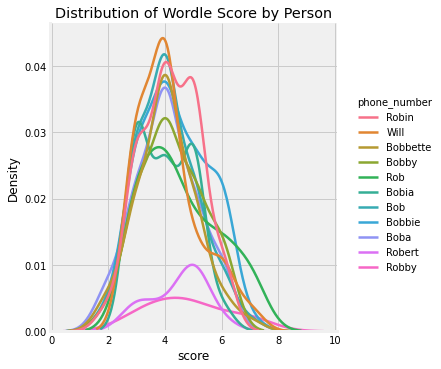

In [43]:
import seaborn as sns


sns.displot(girls_wordle, x="score", hue="phone_number", kind = "kde",
            linewidth = 2.5).set(title = "Distribution of Wordle Score by Person")
plt.savefig('girls_wordle_group.png', dpi=300, bbox_inches='tight')


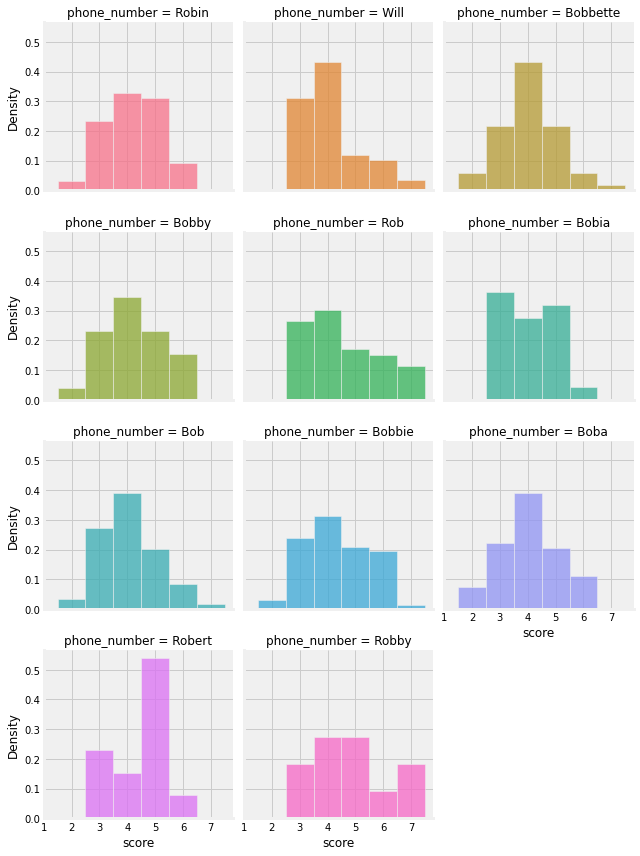

In [44]:
h = sns.FacetGrid(girls_wordle, col='phone_number', hue='phone_number', col_wrap = 3)
h.map(sns.histplot, "score", discrete = True, stat = "density")
h.set(xticks=[1, 2, 3, 4, 5, 6, 7])
h.set_xticklabels([1, 2, 3, 4, 5, 6, 7])
plt.savefig('girls_wordle_indiv.png', dpi=300)

In [45]:
girls_wordle.groupby("phone_number")['score'].describe().sort_values('mean', ascending=True).reset_index()

,phone_number,count,mean,std,min,25%,50%,75%,max
0,Bobia,47.0,4.042553,0.931512,3.0,3.0,4.0,5.00,6.0
1,Boba,54.0,4.055556,1.088823,2.0,3.0,4.0,5.00,6.0
2,Bobbette,51.0,4.058824,1.047125,2.0,3.0,4.0,5.00,7.0
3,Bob,59.0,4.084746,1.055170,2.0,3.0,4.0,5.00,7.0
4,Will,58.0,4.120690,1.077319,3.0,3.0,4.0,4.75,7.0
5,Robin,64.0,4.203125,1.010731,2.0,3.0,4.0,5.00,6.0
6,Bobby,52.0,4.230769,1.095720,2.0,3.0,4.0,5.00,6.0
7,Bobbie,67.0,4.343284,1.174892,2.0,3.0,4.0,5.00,7.0
8,Robert,13.0,4.461538,0.967418,3.0,4.0,5.0,5.00,6.0
9,Rob,53.0,4.547170,1.338283,3.0,3.0,4.0,6.00,7.0


/Users/williamfoote/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


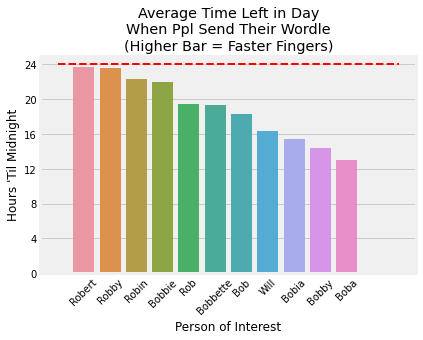

In [50]:
ttm_agged = girls_wordle.groupby("phone_number")['TimeTilMidnight'].mean().sort_values(ascending = False)
sns.barplot(ttm_agged.index, ttm_agged.values).set(
    title='Average Time Left in Day\nWhen Ppl Send Their Wordle\n(Higher Bar = Faster Fingers)',
    xlabel='Person of Interest', ylabel="Hours 'Til Midnight", ylim = (0, 25))
line1, = plt.plot([-1, 12], [24, 24], '--', linewidth=2, color='red')
plt.xticks(rotation = 45)
plt.yticks(np.arange(28, step = 4))
plt.savefig('girls_wordle_speed_high.png', dpi=300, bbox_inches='tight')

/Users/williamfoote/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


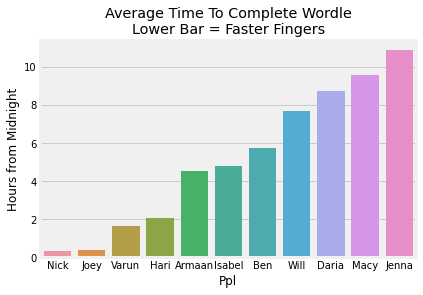

In [40]:
hrmin_agged = girls_wordle.groupby("phone_number")['HourMin'].mean().sort_values(ascending = True)
sns.barplot(ttm_agged.index, hrmin_agged.values).set(
    title='Average Time To Complete Wordle\nLower Bar = Faster Fingers',
    xlabel='Ppl', ylabel='Hours from Midnight')
plt.savefig('girls_wordle_speed.png', dpi=300)

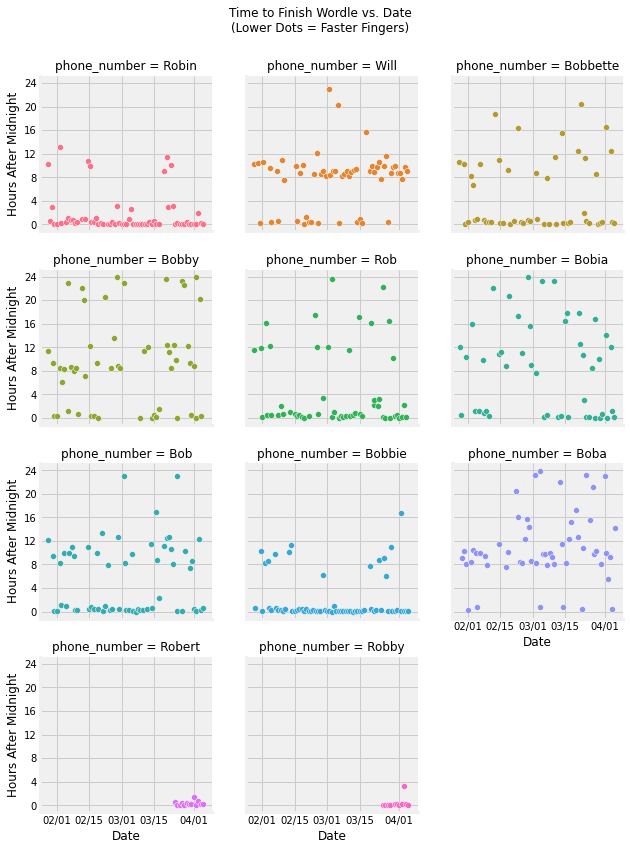

In [79]:
g = sns.FacetGrid(girls_wordle, hue = 'phone_number', col = 'phone_number', col_wrap = 3)
g.map(sns.scatterplot, "timestamp", "HourMin")

g.set(xlabel='Date', ylabel='Hours After Midnight')
g.fig.subplots_adjust(top=.9) # adjust the Figure in rp
g.fig.suptitle('Time to Finish Wordle vs. Date\n(Lower Dots = Faster Fingers)')

# Editing labels and titles with plt

# I want the date to be reformatted nicely on the x-axis ticks
loc, labels = plt.xticks()
plt.xticks(loc, ['02/01', '02/15', '03/01', '03/15', '04/01'])

# And I want hours til midnight to be plotted on the y-axis ticks
plt.yticks(np.arange(28, step = 4))
plt.savefig('girls_wordle_speed_scatter.png', dpi=300, bbox_inches='tight')
